Nutrition Score: 9.999580383300781, Mantle Score: 0.7035050085186958


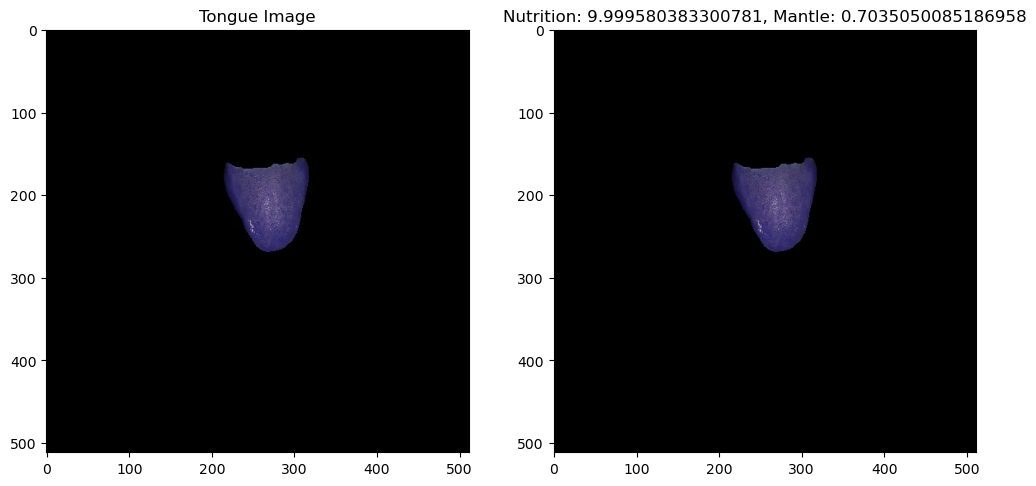

In [230]:
def compute_scores(features):
    coating, jagged_shape, cracks, papillae_size, redness = features
    nutrition_score = 10 - coating + papillae_size + redness
    mantle_score = cracks + jagged_shape
    return nutrition_score, mantle_score

# Example of computing scores
features = [coating_score, jagged_score, cracks_score, papillae_size, redness_score]
nutrition_score, mantle_score = compute_scores(features)

print(f"Nutrition Score: {nutrition_score}, Mantle Score: {mantle_score}")
def visualize_results(image, scores):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(image)
    ax[0].set_title("Tongue Image")
    
    ax[1].imshow(image)
    ax[1].set_title(f"Nutrition: {scores[0]}, Mantle: {scores[1]}")
    
    plt.show()

# Visualizing the results
visualize_results(cropped_tongue_image, [nutrition_score, mantle_score])
def compute_scores(coating, jagged_shape, cracks, papillae_size, redness):
    nutrition_score = 10 - coating + papillae_size + redness
    mantle_score = cracks + jagged_shape
    return nutrition_score, mantle_score

# Preprocessing pipeline
def load_label(image_path):
    with open(image_path, 'r') as f:
        lines = f.readlines()

    # Convert to a list of lists of floats
    return [list(map(float, line.strip().split())) for line in lines]

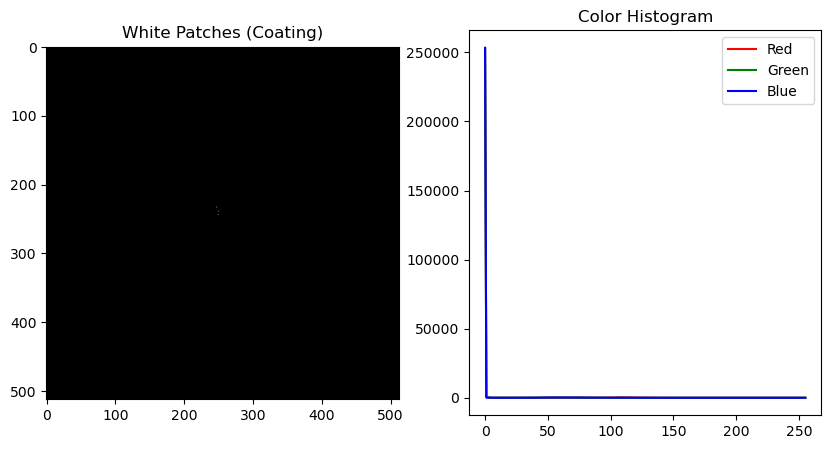

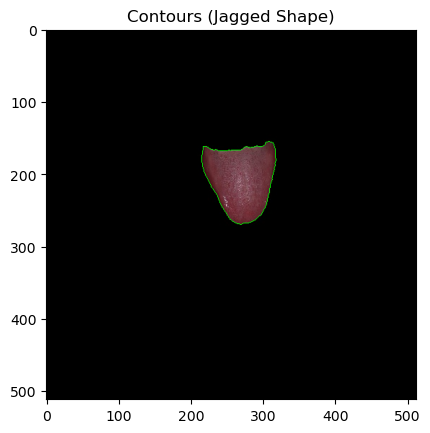

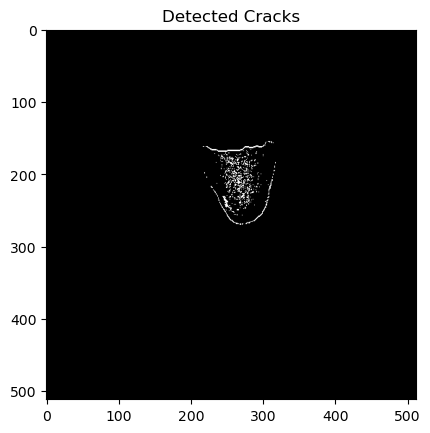

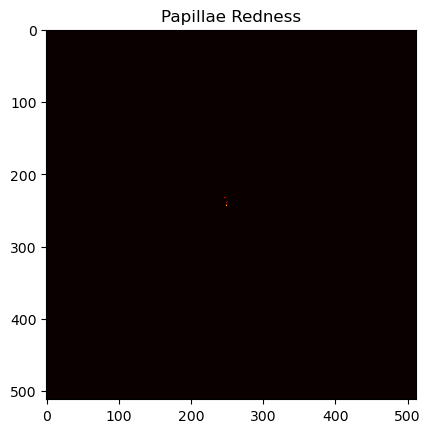

In [232]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from transformers import pipeline
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import torch
import requests
from PIL import Image
# Load the segmented tongue image (grayscale or RGB)
import pandas as pd

# If needed, convert the image to RGB (if it's not in that format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Step 1: Coating Feature Extraction (using color histograms and white patches)
def extract_coating_features(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Threshold to find white patches (coating)
    _, thresholded = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    
    # Color histogram analysis for coating detection (red, green, blue)
    hist_red = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_green = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_blue = cv2.calcHist([image], [2], None, [256], [0, 256])
    
    # Display histogram and white patches
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(thresholded, cmap='gray')
    plt.title("White Patches (Coating)")
    plt.subplot(1, 2, 2)
    plt.plot(hist_red, color='r', label='Red')
    plt.plot(hist_green, color='g', label='Green')
    plt.plot(hist_blue, color='b', label='Blue')
    plt.title("Color Histogram")
    plt.legend()
    plt.show()

    return thresholded, hist_red, hist_green, hist_blue

# Step 2: Jagged Shape Feature Extraction (Contour detection)
def extract_jagged_shape_features(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Use Canny edge detector to find jagged contours
    edges = cv2.Canny(gray, 100, 200)
    
    # Find contours using OpenCV
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw contours on the original image
    contour_image = image.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 1)

    # Display the contours
    plt.imshow(contour_image)
    plt.title("Contours (Jagged Shape)")
    plt.show()

    return contours, contour_image

# Step 3: Cracks Detection using Edge Detection
def extract_cracks_features(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Use Laplacian to detect edges/cracks
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian_abs = cv2.convertScaleAbs(laplacian)
    
    # Thresholding the image to emphasize the cracks
    _, cracks = cv2.threshold(laplacian_abs, 50, 255, cv2.THRESH_BINARY)
    
    # Display the cracks
    plt.imshow(cracks, cmap='gray')
    plt.title("Detected Cracks")
    plt.show()

    return cracks

# Step 4: Papillae Size & Redness Detection (Localized patch analysis)
def extract_papillae_features(image):
    # Convert to RGB (if grayscale image)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Redness measurement - check for high red channel values
    red_channel = image_rgb[:, :, 0]  # Assuming the red channel signifies redness
    
    # Use a simple threshold to find areas of high redness
    _, redness_map = cv2.threshold(red_channel, 180, 255, cv2.THRESH_BINARY)
    
    # Find connected components to calculate papillae size
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(redness_map)
    
    # Display papillae regions
    plt.imshow(redness_map, cmap='hot')
    plt.title("Papillae Redness")
    plt.show()

    return redness_map, num_labels, stats

# Call the functions to extract and visualize features
processed_img=image_rgb
coating_features = extract_coating_features(image_rgb)
jagged_features = extract_jagged_shape_features(image_rgb)
cracks_features = extract_cracks_features(image_rgb)
papillae_features = extract_papillae_features(image_rgb)


In [234]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# If needed, convert the image to RGB (if it's not in that format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
def estimate_coating(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_white = np.array([0, 0, 180])
    upper_white = np.array([255, 60, 255])
    white_mask = cv2.inRange(hsv_image, lower_white, upper_white)
    coating_area = np.sum(white_mask) / (image.shape[0] * image.shape[1] * 255)
    return min(10, coating_area * 10), white_mask

def estimate_jagged_shape(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return 0, edges
    jaggedness = sum([cv2.arcLength(cnt, False) for cnt in contours]) / len(contours)
    return min(10, jaggedness / 100), edges

def estimate_cracks(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, threshold_image = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
    edges = cv2.Canny(threshold_image, 50, 150)
    cracks = np.sum(edges) / (image.shape[0] * image.shape[1] * 255)
    return min(10, cracks * 10), edges

def estimate_papillae(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])
    red_mask = cv2.inRange(hsv_image, lower_red, upper_red)
    red_area = np.sum(red_mask) / (image.shape[0] * image.shape[1] * 255)
    papillae_size = min(10, red_area * 10)
    redness = papillae_size
    return papillae_size, redness, red_mask

# Replace with your actual tongue image
cropped_tongue_image = image

# Run estimations
coating_score, coating_mask = estimate_coating(cropped_tongue_image)
jagged_score, jagged_edges = estimate_jagged_shape(cropped_tongue_image)
cracks_score, crack_edges = estimate_cracks(cropped_tongue_image)
papillae_size, redness_score, red_mask = estimate_papillae(cropped_tongue_image)

# Print scores
print(f"Coating: {coating_score:.2f}")
print(f"Jagged Shape: {jagged_score:.2f}")
print(f"Cracks: {cracks_score:.2f}")
print(f"Papillae Size: {papillae_size:.2f}")
print(f"Redness: {redness_score:.2f}")

# Plot results
# plt.figure(figsize=(12, 8))

# plt.subplot(2, 3, 1)
# plt.imshow(cropped_tongue_image)
# plt.title("Original Image")
# plt.axis("off")

# plt.subplot(2, 3, 2)
# plt.imshow(coating_mask, cmap='gray')
# plt.title("Coating Mask")
# plt.axis("off")

# plt.subplot(2, 3, 3)
# plt.imshow(jagged_edges, cmap='gray')
# plt.title("Jagged Edges")
# plt.axis("off")

# plt.subplot(2, 3, 4)
# plt.imshow(crack_edges, cmap='gray')
# plt.title("Crack Edges")
# plt.axis("off")

# plt.subplot(2, 3, 5)
# plt.imshow(red_mask, cmap='gray')
# plt.title("Red Mask (Papillae)")
# plt.axis("off")

# plt.tight_layout()
# plt.show()


Coating: 0.00
Jagged Shape: 0.68
Cracks: 0.02
Papillae Size: 0.00
Redness: 0.00


In [248]:
# Example of computing scores
features = [coating_score, jagged_score, cracks_score, papillae_size, redness_score]
nutrition_score, mantle_score = compute_scores(features)

print(f"Nutrition Score: {nutrition_score}, Mantle Score: {mantle_score}")


TypeError: compute_scores() missing 4 required positional arguments: 'jagged_shape', 'cracks', 'papillae_size', and 'redness'

In [250]:
# Feature Prediction:

In [252]:
image_dir = '/home/newuser/Downloads/final_tongue/tongue_only_final'
# Load image files
image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith(('jpg', 'jpeg', 'png'))]
inputs=[cv2.imread(path) for path in image_files ]

In [254]:

# Extract features using list comprehensions (kept the same)
feature1vector = [estimate_coating(img)[0] for img in inputs]          # coating_score
feature2vector = [estimate_jagged_shape(img)[0] for img in inputs]     # jagged_score
feature3vector = [estimate_cracks(img)[0] for img in inputs]           # cracks_score
feature4vector = [estimate_papillae(img)[0] for img in inputs]         # papillae_size
feature5vector = [estimate_papillae(img)[1] for img in inputs]         # redness_score

# Stack features column-wise directly for efficiency
features = np.column_stack([
    feature1vector,   # 0: coating_score
    feature2vector,   # 1: jagged_score
    feature3vector,   # 2: cracks_score
    feature4vector,   # 3: papillae_size
    feature5vector    # 4: redness_score
])

# Compute scores
nuScore = 10 - features[:, 0] + features[:, 3] + features[:, 4]    # coating, papillae, redness
manScore = features[:, 2] + features[:, 1]                         # cracks + jagged

# Concatenate scores to the right
finalData = np.column_stack([features, nuScore, manScore])

# Optional: Convert to DataFrame with column names
column_names = [
    'coating_score', 'jagged_score', 'cracks_score', 
    'papillae_size', 'redness_score', 
    'nu_score', 'mantle_score'
]

final_df = pd.DataFrame(finalData, columns=column_names)

print(final_df.head())


   coating_score  jagged_score  cracks_score  papillae_size  redness_score  \
0       0.001640      0.696184      0.031471            0.0            0.0   
1       0.000038      1.291899      0.057602            0.0            0.0   
2       0.000114      0.458509      0.015106            0.0            0.0   
3       0.006752      1.063322      0.199089            0.0            0.0   
4       0.001221      1.358840      0.093498            0.0            0.0   

   nu_score  mantle_score  
0  9.998360      0.727655  
1  9.999962      1.349501  
2  9.999886      0.473615  
3  9.993248      1.262411  
4  9.998779      1.452338  


In [256]:
final_df

,coating_score,jagged_score,cracks_score,papillae_size,redness_score,nu_score,mantle_score
0,0.001640,0.696184,0.031471,0.0,0.0,9.998360,0.727655
1,0.000038,1.291899,0.057602,0.0,0.0,9.999962,1.349501
2,0.000114,0.458509,0.015106,0.0,0.0,9.999886,0.473615
3,0.006752,1.063322,0.199089,0.0,0.0,9.993248,1.262411
4,0.001221,1.358840,0.093498,0.0,0.0,9.998779,1.452338
...,...,...,...,...,...,...,...
370,0.003052,0.851869,0.035324,0.0,0.0,9.996948,0.887194
371,1.519661,10.000000,0.038490,0.0,0.0,8.480339,10.038490
372,0.000000,10.000000,0.168533,0.0,0.0,10.000000,10.168533
373,1.624756,10.000000,0.054169,0.0,0.0,8.375244,10.054169


In [275]:
label_dir='/home/newuser/Downloads/tongue_dataset/train/labels'
label_files = [os.path.join(label_dir, file) for file in os.listdir(label_dir) if file.endswith(('txt'))]
# Process all images
labels = ([load_label(img) for img in label_files])
labels2=np.zeros((len(labels),5))

for i in range(0,len(labels)):
    for j in range(0,5):
        labels2[i,j]=np.array(labels[i])[0,j]
label_tensor =  torch.from_numpy(labels2)[:,0]



### multiClass Classifier using the first 3 Features 

In [277]:
y=label_tensor
X=np.asarray(final_df)[:,0:3]

In [263]:
X.shape

(375, 3)

In [265]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader, TensorDataset


/tmp/ipykernel_6937/1803218182.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
/tmp/ipykernel_6937/1803218182.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y =torch.tensor(y, dtype=torch.long )


Epoch 1/100, Loss: 1.6072
Epoch 2/100, Loss: 1.3583
Epoch 3/100, Loss: 1.2154
Epoch 4/100, Loss: 1.0930
Epoch 5/100, Loss: 0.9975
Epoch 6/100, Loss: 0.9281
Epoch 7/100, Loss: 0.8783
Epoch 8/100, Loss: 0.8586
Epoch 9/100, Loss: 0.8396
Epoch 10/100, Loss: 0.8382
Epoch 11/100, Loss: 0.8317
Epoch 12/100, Loss: 0.8283
Epoch 13/100, Loss: 0.8269
Epoch 14/100, Loss: 0.8260
Epoch 15/100, Loss: 0.8260
Epoch 16/100, Loss: 0.8216
Epoch 17/100, Loss: 0.8245
Epoch 18/100, Loss: 0.8250
Epoch 19/100, Loss: 0.8206
Epoch 20/100, Loss: 0.8212
Epoch 21/100, Loss: 0.8198
Epoch 22/100, Loss: 0.8249
Epoch 23/100, Loss: 0.8242
Epoch 24/100, Loss: 0.8271
Epoch 25/100, Loss: 0.8197
Epoch 26/100, Loss: 0.8198
Epoch 27/100, Loss: 0.8165
Epoch 28/100, Loss: 0.8126
Epoch 29/100, Loss: 0.8098
Epoch 30/100, Loss: 0.8259
Epoch 31/100, Loss: 0.8188
Epoch 32/100, Loss: 0.8126
Epoch 33/100, Loss: 0.8150
Epoch 34/100, Loss: 0.8148
Epoch 35/100, Loss: 0.8191
Epoch 36/100, Loss: 0.8115
Epoch 37/100, Loss: 0.8170
Epoch 38/1

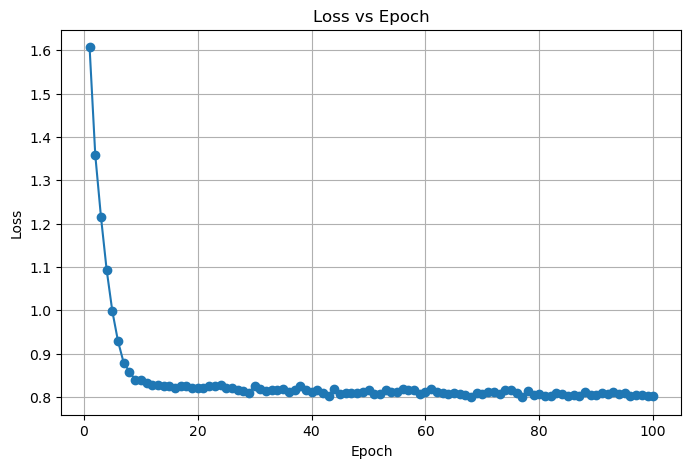

In [297]:


X = torch.tensor(X, dtype=torch.float)  
y =torch.tensor(y, dtype=torch.long ) 



# DataLoaders
train_loader = DataLoader(TensorDataset(X, y), batch_size=32, shuffle=True)
# test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

# MLP Model
class MLP(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_classes=6):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training with loss tracking
num_epochs = 100
loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Plot Loss vs Epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_history, marker='o')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()



## Test Data:

In [299]:
image_dir = '/home/newuser/Downloads/final_tongue/tongue_only_valid'
# Load image files
image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith(('jpg', 'jpeg', 'png'))]
inputs=[cv2.imread(path) for path in image_files ]
# Extract features using list comprehensions (kept the same)
feature1vector = [estimate_coating(img)[0] for img in inputs]          # coating_score
feature2vector = [estimate_jagged_shape(img)[0] for img in inputs]     # jagged_score
feature3vector = [estimate_cracks(img)[0] for img in inputs]           # cracks_score
feature4vector = [estimate_papillae(img)[0] for img in inputs]         # papillae_size
feature5vector = [estimate_papillae(img)[1] for img in inputs]         # redness_score

# Stack features column-wise directly for efficiency
features = np.column_stack([
    feature1vector,   # 0: coating_score
    feature2vector,   # 1: jagged_score
    feature3vector,   # 2: cracks_score
    feature4vector,   # 3: papillae_size
    feature5vector    # 4: redness_score
])

# Compute scores
nuScore = 10 - features[:, 0] + features[:, 3] + features[:, 4]    # coating, papillae, redness
manScore = features[:, 2] + features[:, 1]                         # cracks + jagged

# Concatenate scores to the right
finalData_test = np.column_stack([features, nuScore, manScore])

# Optional: Convert to DataFrame with column names
column_names = [
    'coating_score', 'jagged_score', 'cracks_score', 
    'papillae_size', 'redness_score', 
    'nu_score', 'mantle_score'
]

final_df_test = pd.DataFrame(finalData_test, columns=column_names)

print(final_df.head())

   coating_score  jagged_score  cracks_score  papillae_size  redness_score  \
0       0.001640      0.696184      0.031471            0.0            0.0   
1       0.000038      1.291899      0.057602            0.0            0.0   
2       0.000114      0.458509      0.015106            0.0            0.0   
3       0.006752      1.063322      0.199089            0.0            0.0   
4       0.001221      1.358840      0.093498            0.0            0.0   

   nu_score  mantle_score  
0  9.998360      0.727655  
1  9.999962      1.349501  
2  9.999886      0.473615  
3  9.993248      1.262411  
4  9.998779      1.452338  


In [301]:
# Evaluation: Confusion Matrix & Metrics
label_dir='/home/newuser/Downloads/tongue_dataset/valid/labels'
label_files = [os.path.join(label_dir, file) for file in os.listdir(label_dir) if file.endswith(('txt'))]
# Process all images
labels = ([load_label(img) for img in label_files])
labels2=np.zeros((len(labels),5))

for i in range(0,len(labels)):
    for j in range(0,5):
        labels2[i,j]=np.array(labels[i])[0,j]
label_tensor_test =  torch.from_numpy(labels2)[:,0]


/tmp/ipykernel_6937/1524159636.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test =torch.tensor(y_test, dtype=torch.float )


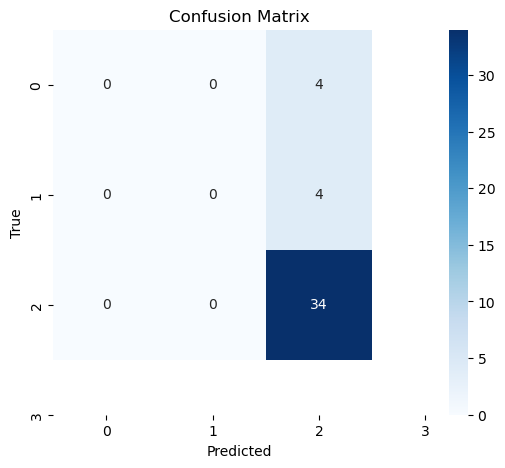


Classification Report:

              precision    recall  f1-score   support

         1.0   0.000000  0.000000  0.000000         4
         3.0   0.000000  0.000000  0.000000         4
         5.0   0.809524  1.000000  0.894737        34

    accuracy                       0.809524        42
   macro avg   0.269841  0.333333  0.298246        42
weighted avg   0.655329  0.809524  0.724311        42



/home/newuser/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/newuser/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/newuser/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [303]:



y_test=label_tensor_test
X_test=np.asarray(final_df_test)[:,0:3]

X_test = torch.tensor(X_test, dtype=torch.float)  
y_test =torch.tensor(y_test, dtype=torch.float ) 
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)
label_tensor
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, digits=6))


In [309]:
np.asarray([all_preds,all_labels])

array([[5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 3., 5., 5., 5., 1., 5., 5., 5., 5., 5., 5.,
        5., 1., 5., 5., 5., 1., 5., 5., 5., 5., 5., 5., 1., 5., 5., 3.,
        5., 5., 5., 5., 5., 5., 5., 3., 5., 3.]])